### Extract LPI data

In [9]:
import pandas as pd
species = 'mouse'

lppi = pd.read_csv(f'../../annotate/{species}/valid_inter.csv')

lpi = lppi[lppi.iloc[:, 0].str.startswith('l')]
lpi = lpi[['source', 'target']]
lpi.columns = ['lncRNA_id', 'protein_id']
lpi.to_csv(f'{species}_lpi.csv', index=False)

### Extract mouse essenrial protein & human essential protein

In [ ]:
import pandas as pd

protein = pd.read_csv(f'../../data/LPPI/mouse/protein_updated.csv')
ess_protein = pd.read_csv('Mus musculus_genes.csv')

ess_protein = ess_protein[['gene', 'essentiality']]
ess_protein = ess_protein[(ess_protein['essentiality'] == 'E')]
ess_protein_lpi = protein[protein['protein'].isin(ess_protein['gene'])]
ess_protein_id = ess_protein_lpi['protein_id']

ess_protein_id.to_csv(f'mouse_ess_protein_id.csv', index=False)

In [5]:
import pandas as pd

protein = pd.read_csv('../../data/LPPI/human/protein_updated.csv')
ess_protein = pd.read_csv('CSEGs_CEGs.txt', sep='\t')

ess_protein = ess_protein[['gene', 'essentiality']]
ess_protein = ess_protein[ess_protein['essentiality'] == 'CEGs']

ess_protein_lpi = protein[protein['protein'].isin(ess_protein['gene'])]
ess_protein_id = ess_protein_lpi['protein_id']

ess_protein_id.to_csv(f'human_ess_protein_id.csv', index=False)

### Test the correlation between lncRNA essentiality and the essentiality of interacting proteins.

In [10]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
species = 'mouse'

# Load essential proteins
essential_proteins = pd.read_csv(f'{species}_ess_protein_id.csv')
essential_protein_set = set(essential_proteins.iloc[:, 0])

# Load lncRNA-protein interaction pairs
interactions = pd.read_csv(f'{species}_lpi.csv')

# Load essential lncRNAs (must be provided)
essential_lncrnas = pd.read_csv(f'../../data/benchmark/{species}/ess_lnc.csv')
non_essential_lncrnas = pd.read_csv(f'../../data/benchmark/{species}/noness_lnc.csv')

# Convert to set for faster lookup
non_essential_lncrna_set = set(non_essential_lncrnas.iloc[:, 0])
essential_lncrna_set = set(essential_lncrnas.iloc[:, 0])

# lncRNAs interacting with essential proteins
lnc_with_essential = set(interactions[interactions['protein_id'].isin(essential_protein_set)]['lncRNA_id'])

# All interacting lncRNAs
all_lncrnas = set(interactions['lncRNA_id'])

# lncRNAs NOT interacting with essential proteins
lnc_without_essential = all_lncrnas - lnc_with_essential

# Convert to set for faster lookup
non_essential_lncrna_set = set(non_essential_lncrnas.iloc[:, 0])

# a: essential lncRNA & interacts with essential protein
a = len(essential_lncrna_set & lnc_with_essential)

# b: non-essential lncRNA & interacts with essential protein
b = len(non_essential_lncrna_set & lnc_with_essential)

# c: essential lncRNA & does NOT interact with essential protein
c = len(essential_lncrna_set & lnc_without_essential)

# d: non-essential lncRNA & does NOT interact with essential protein
d = len(non_essential_lncrna_set & lnc_without_essential)

# Construct contingency table
contingency_table = [[a, b], [c, d]]

# Perform chi-squared test
chi2, p_chi2, _, _ = chi2_contingency(contingency_table)

# Perform Fisher's exact test
odds_ratio, p_fisher = fisher_exact(contingency_table)

# Save results to a TXT file
output_file = f'{species}_lncrna_enrichment_result.txt'
with open(output_file, 'w') as f:
    f.write("Contingency Table (2x2):\n")
    f.write("        | Essential lncRNA | Non-essential lncRNA\n")
    f.write("--------|------------------|----------------------\n")
    f.write(f"Interact|       {a}          |         {b}\n")
    f.write(f"NoIntact|       {c}          |         {d}\n\n")

    f.write(f"Chi2 statistic: {chi2}\n")
    f.write(f"Chi-squared test p-value: {p_chi2}\n")
    f.write(f"Fisher's exact test p-value: {p_fisher}\n")
    f.write(f"Odds Ratio: {odds_ratio}\n\n")

    f.write("Proportion of essential lncRNAs:\n")
    f.write(f"Interact: {a / (a + b):.3f}\n")
    f.write(f"NoInteract: {c / (c + d):.3f}\n")

print(f"\nResults saved to {output_file}")





Results saved to mouse_lncrna_enrichment_result.txt


### The interaction between the predicted essential lncRNA and the essential protein.

In [13]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
species = 'human'

# Load essential proteins
essential_proteins = pd.read_csv(f'{species}_ess_protein_id.csv')
essential_protein_set = set(essential_proteins.iloc[:, 0])

# Load lncRNA-protein interaction pairs
interactions = pd.read_csv(f'{species}_lpi.csv')

# Load essential lncRNAs (must be provided)
essential_lncrnas = pd.read_csv(f'../../results/{species}/{species}_essential_genes_union.csv')

# Convert to set for faster lookup
essential_lncrna_set = set(essential_lncrnas.iloc[:, 0])

# lncRNAs interacting with essential proteins
lnc_with_essential = set(interactions[interactions['protein_id'].isin(essential_protein_set)]['lncRNA_id'])

# All interacting lncRNAs
all_lncrnas = set(interactions['lncRNA_id'])

# lncRNAs NOT interacting with essential proteins
lnc_without_essential = all_lncrnas - lnc_with_essential


# a: essential lncRNA & interacts with essential protein
a = len(essential_lncrna_set & lnc_with_essential)

# b: essential lncRNA & does NOT interacts with essential protein
b = len(essential_lncrna_set & lnc_without_essential)

# Output
print("The ratio of essential lncRNAs interacting with essential proteins is:", a / (a + b))



The ratio of essential lncRNAs interacting with essential proteins is: 0.8116808718736901


### The number of essential protein interact with lncRNA gene in benchmark dataset.

/tmp/ipykernel_58748/1698410877.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='label', y='log_count', data=df_count, palette='Set2')


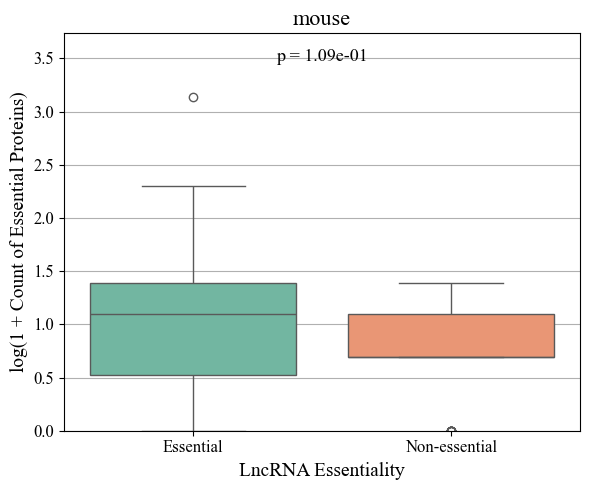

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from collections import defaultdict
from matplotlib import rcParams
import numpy as np
rcParams['font.family'] = 'Times New Roman'

# =====================
# Step 1: Load data
# =====================
species = 'mouse'
interactions = pd.read_csv(f'{species}_lpi.csv')
essential_proteins = pd.read_csv(f'{species}_ess_protein_id.csv')
essential_lncrnas = pd.read_csv(f'../../data/benchmark/{species}/ess_lnc.csv')
non_essential_lncrnas = pd.read_csv(f'../../data/benchmark/{species}/noness_lnc.csv')

# =====================
# Step 2: Build mapping
# =====================
essential_protein_set = set(essential_proteins.iloc[:, 0])
essential_lncrna_set = set(essential_lncrnas.iloc[:, 0])
non_essential_lncrna_set = set(non_essential_lncrnas.iloc[:, 0])

protein_essential_map = {p: (p in essential_protein_set) for p in interactions['protein_id'].unique()}

lnc_protein_map = defaultdict(list)
for _, row in interactions.iterrows():
    lnc = row['lncRNA_id']
    prot = row['protein_id']
    lnc_protein_map[lnc].append(prot)

# =====================
# Step 3: Compute counts and log(count)
# =====================
data = []
for lnc, proteins in lnc_protein_map.items():
    if len(proteins) == 0:
        continue
    ess_count = sum(protein_essential_map[p] for p in proteins)
    if lnc in essential_lncrna_set:
        label = 'Essential'
    elif lnc in non_essential_lncrna_set:
        label = 'Non-essential'
    else:
        continue
    data.append((lnc, ess_count, np.log1p(ess_count), label))

df_count = pd.DataFrame(data, columns=['lncRNA', 'count', 'log_count', 'label'])

# =====================
# Step 4: Plot boxplot + log(count)
# =====================
plt.figure(figsize=(6, 5))
ax = sns.boxplot(x='label', y='log_count', data=df_count, palette='Set2')

# set x-ticks and labels
ax.set_title(f'{species}', fontsize=16)
ax.set_ylabel('log(1 + Count of Essential Proteins)', fontsize=14)
ax.set_xlabel('LncRNA Essentiality', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.grid(True, axis='y')

# Mann-Whitney U test
group1 = df_count[df_count['label'] == 'Essential']['log_count']
group2 = df_count[df_count['label'] == 'Non-essential']['log_count']
stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

# show p value
y_max = df_count['log_count'].max()
y_loc = y_max + 0.3
ax.text(0.5, y_loc, f"p = {p_value:.2e}", ha='center', va='bottom', fontsize=13)

plt.ylim(0, y_loc + 0.3)
plt.tight_layout()
plt.savefig(f'{species}_log_essential_protein_count_boxplot.svg')
plt.show()
